## Importing Libraries

In [1]:
import numpy as np # Importing NumPy for numerical computing, such as array operations and mathematical functions.
import matplotlib.pyplot as plt # Importing Pyplot from Matplotlib for data visualization and plotting graphs.
from matplotlib import cm # Importing 'cm' from Matplotlib for access to color maps used in plotting.
from scipy.special import erfc # Importing 'erfc' (complementary error function) from SciPy's special functions module.
import pandas as pd # Importing Pandas for data manipulation and analysis, particularly for structured data operations.
from modem import PSKModem, QAMModem, PAMModem, FSKModem # Importing various modem types (Phase Shift Keying, Quadrature Amplitude Modulation, Pulse Amplitude Modulation, Frequency Shift Keying) from a custom 'modem' module.
from channels import awgn, rayleighFading, TSMG # Importing functions for simulating different types of channels: Additive White Gaussian Noise, Rayleigh Fading, and TSMG (possibly a custom channel type) from a custom 'channels' module.
from errorRates import ser_rayleigh # Importing a function to calculate symbol error rate in Rayleigh fading channel conditions from a custom 'errorRates' module.
from tqdm.notebook import tqdm # Importing 'tqdm' from tqdm.notebook for displaying progress bars in Jupyter notebooks.


## Defining the WSN Simulation Environment

In [9]:
##Environment parameters

class WSN_environment():

####################################################### Initialization ########################################################################

    def __init__(self,nb_selected_relays = 2, M=3, Tc = 20,Env_size = 30,Modem_type='QAM',Mod_order = 4,p_B = 0,R = 20,NOISE_MEMORY=20,random_seed = 10):
        # Initialization method for the WSN_environment class.
        # Parameters:
        # M: Number of nodes in the network.
        # Tc: Coherence Time in symbol duration.
        # Env_size: Size of the environment.
        # Modem_type: Type of modem used (PSK, QAM, PAM).
        # Mod_order: Modulation order.
        # p_B, R, NOISE_MEMORY: Parameters for noise model.
        # random_seed: Seed for random number generation.
        self.M = M 
        self.p_B = p_B 
        self.R = R 
        self.NOISE_MEMORY = NOISE_MEMORY
        self.nb_selected_relays = nb_selected_relays
        
        #Tc/Ts ratio:
        self.Tc =  Tc 
        #Modulation parameters
        modem_dict = {'psk': PSKModem,'qam':QAMModem,'pam':PAMModem}
        self.Modem = modem_dict[Modem_type.lower()](Mod_order)
        self.Mod_order = Mod_order 

        #nodes and links characteristics and 
        self.Env_size = Env_size 
        self.node_positions = self.init_positions()
        self.node_battery_states = np.ones(M-1) * 100000
        
        self.links_CSI = pd.DataFrame(columns=['link','h','h_abs','G/B'])
        self.initiate_links()

        self.visualize()
        print('Initial link CSIs :')
        print(self.links_CSI.head(10))


    def init_positions(self):
        # Initializes positions of nodes in the network.

        while True :

            node_positions = np.array([np.random.randint(0,self.Env_size,self.M),np.random.randint(0,self.Env_size,self.M)]).T
            node_positions[0] = np.array([0,self.Env_size-1])
            node_positions[-1] = np.array([self.Env_size-1,0])
            found_positions = True
            for i in range(len(node_positions)):
                for j in range(len(node_positions)):
                    if j!=i and node_positions[i][0] == node_positions[j][0] and node_positions[i][1] == node_positions[j][1]:
                        found_positions = False
            if found_positions:
                break
        return node_positions


    def initiate_links(self): # Initializes the links between nodes and their channel state information (CSI).
        self.links_CSI = pd.DataFrame(columns=['link','distance','h','h_abs','G/B'])
        index = 0
        for i in range(1,self.M+1):
            for j in range(1,self.M+1):
                if i !=j :
                    d = self.distance(i,j)
                    h = np.array(rayleighFading(1,d,2)[0],dtype = 'complex_')
                    self.links_CSI.loc[index] = [str(i)+'->'+str(j),d,h,abs(h),'G']
                    index+=1


    def visualize(self):
        print('visualize  environment :')

        for i, txt in enumerate(np.arange(1,self.M)):
            for j in range(1,self.M):
                plt.annotate("", xy=(self.node_positions[i,0], self.node_positions[i,1]), xytext=(self.node_positions[j,0], self.node_positions[j,1]),
                arrowprops=dict(arrowstyle="<->"))
            
        for i, txt in enumerate(np.arange(1,self.M)):
            plt.annotate(txt, (self.node_positions[i,0]+0.1, self.node_positions[i,1]+0.1),color='green',size=20)
        plt.annotate('D', (self.node_positions[-1,0]+0.1, self.node_positions[-1,1]+0.1),color='blue',size=20)

        plt.scatter(self.node_positions[:,0], self.node_positions[:,1],
            c='g', alpha=0.6, lw=0,s=400)
        plt.scatter(self.node_positions[-1,0], self.node_positions[-1,1], c='g', alpha=0.6, lw=0,s=400  )
        plt.xlim(0,self.Env_size)
        plt.ylim(0,self.Env_size)
        plt.axis('off')
        plt.show()








####################################################### Helpfull functions ########################################################################

    def update_all_links(self):
        # Updates the channel state information (CSI) for all links in the network.
        # This is done by first setting the 'h' column in the links_CSI DataFrame equal to the distance values.
        # Then, it applies the `update_one_link` function to each 'h' value to update the CSI.
        # Finally, it calculates the absolute value of each 'h' and stores it in 'h_abs'.
            
        self.links_CSI['h'] =  self.links_CSI['distance'].values
        self.links_CSI['h'] =  self.links_CSI['h'].apply(self.update_one_link)
        self.links_CSI['h_abs'] =  self.links_CSI['h'].apply(np.abs)



    def update_one_link(self, d):
        # Updates the channel state information for a single link.
        # This function takes the distance 'd' as input and returns the CSI as a complex number.
        # The rayleighFading function is used to model the fading effect on the link based on the distance.
        # The output is formatted as a complex number to represent the amplitude and phase shift caused by the fading.
        return np.array(rayleighFading(1,d,2)[0],dtype = 'complex_')

    def distance(self, node1, node2):
        # Calculates the normalized distance between two nodes in the network.
        # The function computes the Euclidean distance between the positions of node1 and node2.
        # The distance is then normalized with respect to the distance between nodes 1 and 10 in the network.
        # This normalization might be specific to the network layout or design criteria.
        distance_1_to_10 =  np.linalg.norm(self.node_positions[0] - self.node_positions[-1],ord=2) 
        return  np.linalg.norm(self.node_positions[node1-1] - self.node_positions[node2-1],ord=2)/distance_1_to_10





 ####################################################### max-min Relay Selection ################################################################
    def max_min_relay_selection(self, source):
        # Implements the max-min relay selection algorithm.
        # This algorithm selects the relay node that maximizes the minimum channel quality among all possible relay nodes.
        # source: The source node from which the transmission originates.
        
        min_h_of_links = {}  # Dictionary to store the minimum channel quality for each relay.
        for relay in range(1, self.M):
            if relay != source:
                # Extracting the channel quality (absolute value of channel coefficient) for source-relay and relay-destination links.
                SR = self.links_CSI[self.links_CSI.link == str(source)+'->'+str(relay)]['h_abs'].values
                RD = self.links_CSI[self.links_CSI.link == str(relay)+'->'+str(self.M)]['h_abs'].values
                # Storing the minimum of these two values for each relay.
                min_h_of_links[relay] = min(SR, RD)
        # Selecting the relay with the maximum of these minimum values.
        best_relay = max(min_h_of_links, key=min_h_of_links.get)
        return best_relay




    def send_using_max_min(self, noise_type='awgn', source=1, nSym=1000000, EsN0dB=5):
        # Simulates the transmission of symbols using the max-min relay selection strategy.
        # noise_type: Type of noise in the channel (e.g., 'awgn' for Additive White Gaussian Noise).
        # source: The source node for the transmission.
        # nSym: Number of symbols to be transmitted.
        # EsN0dB: Energy per symbol to noise power spectral density ratio, in decibels.

        # Generating random input symbols.
        all_input_syms = np.random.randint(low=0, high=self.Mod_order, size=(nSym//self.Tc)*self.Tc)
        # Initializing arrays to store detected symbols at the destination and through direct transmission.
        all_D_detected_syms = np.zeros(nSym)
        all_SD_detected_syms = np.zeros(nSym)

        # Calculating noise spectral density based on EsN0dB.
        gamma = 10**(EsN0dB/10)  # Converting SNR from dB to linear scale.
        P = sum(abs(all_input_syms)**2)/len(all_input_syms)  # Calculating actual power in the vector.
        N0 = P/gamma  # Noise spectral density.
        
        for time_step in range(nSym//self.Tc):
            self.update_all_links()
            #best_relay = np.random.randint(2,self.M)
            best_relays = self.max_min_relay_selection(source)
            
            input_syms_chunk = all_input_syms[time_step*self.Tc:(time_step+1)*self.Tc]

            #Sending information from S to D
            DT_receivedSyms,h_DT,noise_states_DT = self.send_over_one_link('awgn',input_syms_chunk,source = source,destination = self.M,EsN0dB = EsN0dB)



            ## Sending informations through Relays:
            
            all_h_RDs = []
            D_receivedSyms =  0           #Maximum ratio combiner 
            for best_relay in best_relays :
                #print(" Relay : ",best_relay)
                #Sending information from S to R
                SR_receivedSyms,h_SR,noise_states_SR = self.send_over_one_link(noise_type,input_syms_chunk,source = source,destination = best_relay,EsN0dB = EsN0dB)
                SR_receivedSyms = np.array(h_SR.conjugate()*SR_receivedSyms/abs(h_SR),dtype = 'complex_')
                SR_detectedSyms = self.Modem.demodulate(SR_receivedSyms) #demodulate 

                #Sending information from R to D
                RD_receivedSyms,h_RD,noise_states_RD = self.send_over_one_link('awgn',SR_detectedSyms,source = best_relay,destination = self.M,EsN0dB = EsN0dB)

                RD_receivedSyms = (SR_detectedSyms == input_syms_chunk) * RD_receivedSyms

                all_h_RDs.append(h_RD)

                self.node_battery_states[best_relay-1] -= self.Tc




                #Maximum ratio combiner :
                D_receivedSyms += h_RD.conjugate()* RD_receivedSyms

            D_receivedSyms = np.array(D_receivedSyms,dtype = 'complex_')/ np.linalg.norm(all_h_RDs,ord=2)  #Maximum ratio combiner :

            
            D_detectedSyms = self.Modem.demodulate(D_receivedSyms)                          #demodulate 
            all_D_detected_syms[time_step*self.Tc:(time_step+1)*self.Tc] = D_detectedSyms

            #comparing with direct links
            #RD_receivedSyms = np.array(RD_receivedSyms/h_RD,dtype = 'complex_')
            #RD_detectedSyms = self.Modem.demodulate(RD_receivedSyms)  
            #all_RD_detected_syms[time_step*self.Tc:(time_step+1)*self.Tc] = RD_detectedSyms
            
            #comparing with direct links
            DT_receivedSyms = np.array(h_DT.conjugate()*DT_receivedSyms/abs(h_DT),dtype = 'complex_')
            DT_detectedSyms = self.Modem.demodulate(DT_receivedSyms) #demodulate 
            all_DT_detected_syms[time_step*self.Tc:(time_step+1)*self.Tc] = DT_detectedSyms

        SER_MRC = np.sum(all_D_detected_syms.astype(int) != all_input_syms)/nSym
        SER_DT = np.sum(all_DT_detected_syms.astype(int) != all_input_syms)/nSym
        #print("SER_SD : ",SER_SD)
         
        return SER_MRC,SER_DT



    def send_over_one_link(self, noise_type, inputSyms, source=1, destination=2, EsN0dB=5):
        # Simulates the transmission of symbols over a single link between two nodes.
        # noise_type: Type of noise to be added to the link (e.g., 'awgn' for Additive White Gaussian Noise, 'tsmg' for another type).
        # inputSyms: Array of input symbols to be transmitted.
        # source: The source node for the transmission.
        # destination: The destination node for the transmission.
        # EsN0dB: Energy per symbol to noise power spectral density ratio, in decibels.

        # Modulation of the input symbols.
        modulatedSyms = self.Modem.modulate(inputSyms)

        # Retrieving the channel coefficient 'h' for the specified link.
        h = self.links_CSI[self.links_CSI.link == str(source)+'->'+str(destination)]['h'].to_numpy()[0]

        # Applying fading effect to the modulated symbols.
        fadedSyms = h * modulatedSyms

        # Adding noise based on the specified noise type.
        if noise_type.lower() == 'awgn':
            # Adding Additive White Gaussian Noise.
            receivedSyms = awgn(fadedSyms, EsN0dB)
            noise_states = []

        elif noise_type.lower() == 'tsmg':
            # Adding noise modeled by the TSMG function, potentially representing a different noise model.
            receivedSyms, noise_states = TSMG(fadedSyms, P_B=self.p_B, R=self.R, NOISE_MEMORY=self.NOISE_MEMORY, SNRdB=EsN0dB)

        # Return the received symbols, the channel coefficient, and the noise states.
        return receivedSyms, h, noise_states






 ####################################################### Putting everything together : ################################################################

    def simulate(self,noise_type = 'AWGN',n_iter_per_EsN0dB = 3,source = 1,relay_selection='max-min',
                            nSym = 100000,min_EbN0dB = 0,max_EbN0dB = 50,EbN0dB_step = 5):
        
        EbN0dBs = range(min_EbN0dB,max_EbN0dB+1,EbN0dB_step)
        k = np.log2(self.Mod_order)
        EsN0dBs = 10*np.log10(k)+EbN0dBs # EsN0dB calculation

        if noise_type.lower() == 'awgn' or noise_type.lower() == 'tsmg':
            battery_capacity = len(EbN0dBs) * n_iter_per_EsN0dB * nSym /4
            self.node_battery_states = np.ones(self.M-1) * battery_capacity
            SER_sim_MRC = []
            SER_sim_DT = []
            
            colors = plt.cm.jet(np.linspace(0,1,4)) # colormap
            fig, ax = plt.subplots(nrows=1,ncols = 1)
            #self.update_links()
            
            for EsN0dB in tqdm(EsN0dBs):
                SER_MRC_temp = []
                SER_DT_temp = []
                for iter in range(n_iter_per_EsN0dB):
                    SER_MRC,SER_DT = self.send_using_max_min(noise_type= noise_type, source = source,nSym = nSym,EsN0dB = EsN0dB)
                    SER_MRC_temp.append(SER_MRC)
                    SER_DT_temp.append(SER_DT)

                SER_sim_MRC.append(np.mean(SER_MRC_temp))
                SER_sim_DT.append(np.mean(SER_DT_temp))
        
            ax.semilogy(EbN0dBs,SER_sim_MRC,color = colors[0],marker='o',linestyle='-',label='Sim MRC')
            ax.semilogy(EbN0dBs,SER_sim_DT,color = colors[1],marker='o',linestyle='-',label='Sim DT')

        if noise_type.lower() == 'both':
            battery_capacity =  len(EbN0dBs) * n_iter_per_EsN0dB * nSym /2
            self.node_battery_states = np.ones(self.M-1) *battery_capacity

            SER_sim_MRC_AWGN = []
            SER_sim_DT_AWGN = []
            SER_sim_MRC_TSMG = []
            SER_sim_DT_TSMG = []
            
            colors = plt.cm.jet(np.linspace(0,1,4)) # colormap
            fig, ax = plt.subplots(nrows=1,ncols = 1)
            fig.set_size_inches(10, 6)

            
            for EsN0dB in tqdm(EsN0dBs):
                SER_MRC_temp_AWGN = []
                SER_DT_temp_AWGN = []
                SER_MRC_temp_TSMG = []
                SER_DT_temp_TSMG = []
                for iter in range(n_iter_per_EsN0dB):
                    SER_MRC,SER_DT = self.send_using_max_min(noise_type= 'awgn', source = source,nSym = nSym,EsN0dB = EsN0dB)
                    SER_MRC_temp_AWGN.append(SER_MRC)
                    SER_DT_temp_AWGN.append(SER_DT)
                  
                    SER_MRC,SER_DT = self.send_using_max_min(noise_type= 'tsmg', source = source,nSym = nSym,EsN0dB = EsN0dB)
                    
                    SER_MRC_temp_TSMG.append(SER_MRC)
                    SER_DT_temp_TSMG.append(SER_DT)

                SER_sim_MRC_AWGN.append(np.mean(SER_MRC_temp_AWGN))
                SER_sim_DT_AWGN.append(np.mean(SER_DT_temp_AWGN))
                
                SER_sim_MRC_TSMG.append(np.mean(SER_MRC_temp_TSMG))
                SER_sim_DT_TSMG.append(np.mean(SER_DT_temp_TSMG))
            print("SER_sim_MRC_AWGN : ",SER_sim_MRC_AWGN)
            print("SER_sim_MRC_TSMG : ",SER_sim_MRC_TSMG)
            ax.semilogy(EbN0dBs,SER_sim_DT_AWGN,color = colors[3],marker='o',linestyle='-',label='Sim DT AWGN',markersize = 15)
            ax.semilogy(EbN0dBs,SER_sim_MRC_AWGN,color = colors[1],marker='o',linestyle='-',label='Sim MRC AWGN using max-min',markersize = 15)
            ax.semilogy(EbN0dBs,SER_sim_MRC_TSMG,color = colors[0],marker='H',linestyle='-',label='Sim MRC TSMG using max-min',markersize = 15)
            #ax.semilogy(EbN0dBs,SER_sim_SD_TSMG,color = colors[3],marker='H',linestyle='-',label='Sim DT TSMG',markersize = 15)
            
        """df = pd.DataFrame()
        df['EbN0dBs'] = EbN0dBs
        df['SER_sim_MRC_AWGN'] = SER_sim_MRC_AWGN
        df['SER_sim_DT_AWGN'] = SER_sim_SD_AWGN
        df['SER_sim_MRC_TSMG'] = SER_sim_MRC_TSMG
        df.to_csv('Effect of TSMG.csv',index = False)
        """
        ax.set_xlabel('Eb/N0(dB)',fontsize=15);ax.set_ylabel('SER ($P_s$)',fontsize=15)
        ax.set_title('Probability of Symbol Error over Rayleigh flat fading channel',fontsize=15)
        ax.legend()
        ax.xaxis.set_tick_params(labelsize=20)
        ax.yaxis.set_tick_params(labelsize=20)
        ax.grid(True)
        ax.set_ylim([0.00006, 0])

        fig, ax = plt.subplots(figsize = (10,6))
        remaining_battery_level = self.node_battery_states[1:self.M-1]*100/battery_capacity
        #clrs = ['green' if (x > 20) else 'red' for x in remaining_battery_level ]
        barlist=ax.bar([ str(i+2) for i in np.arange(self.M-2)],remaining_battery_level)
        for i in range(len(remaining_battery_level)):
            if abs(remaining_battery_level[i])<50:
                barlist[i].set_color('r')
            else:
                barlist[i].set_color('g')

        ax.set_title("Remaining Battery level for each node",fontsize = 20)
        ax.set_xlabel("nodes",fontsize = 20)
        ax.set_ylabel("Battery level (%)",fontsize = 20)
        ax.xaxis.set_tick_params(labelsize=20)
        ax.yaxis.set_tick_params(labelsize=20)
        ax.grid(True)


## Simulation Results

visualize  environment :


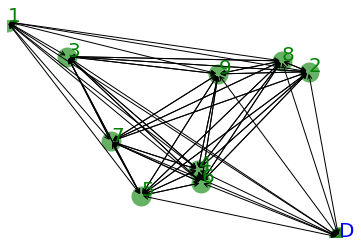

Initial link CSIs :
    link  distance                h     h_abs G/B
0   1->2  0.663483   (1.216-1.124j)  1.655908   G
1   1->3  0.172014   (2.147+0.298j)  2.167582   G
2   1->4  0.633753  (-0.868+2.111j)  2.282487   G
3   1->5  0.638844   (0.464+0.141j)  0.484951   G
4   1->6  0.671546   (0.332-0.284j)  0.436898   G
5   1->7  0.450940   (3.192+1.454j)  3.507560   G
6   1->8  0.599629  (-0.006+0.264j)  0.264068   G
7   1->9  0.481523  (-0.045+2.971j)  2.971341   G
8  1->10  1.000000  (-0.054+0.532j)  0.534734   G
9   2->1  0.663483   (1.285+1.135j)  1.714482   G


In [10]:
env = WSN_environment(M = 10,nb_selected_relays=2, Modem_type='QAM', Tc = 1000, Mod_order=4,Env_size=100,p_B=0.1, R=100, NOISE_MEMORY=100)

  0%|          | 0/11 [00:00<?, ?it/s]

SER_sim_MRC_AWGN :  [0.10095000000000001, 0.031000000000000007, 0.004575, 0.000375, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
SER_sim_MRC_TSMG :  [0.1355, 0.055174999999999995, 0.021150000000000002, 0.011450000000000002, 0.0051, 0.008525, 0.004025, 0.004375, 0.0014249999999999998, 0.001175, 0.00075]


/tmp/ipykernel_4660/2210798567.py:310: UserWarning: Attempted to set non-positive top ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim([0.00006, 0])


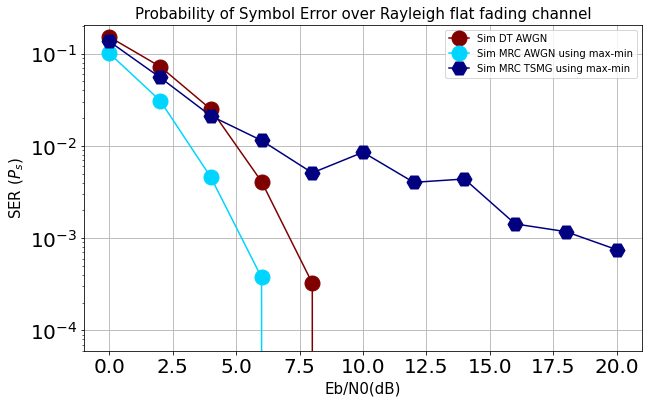

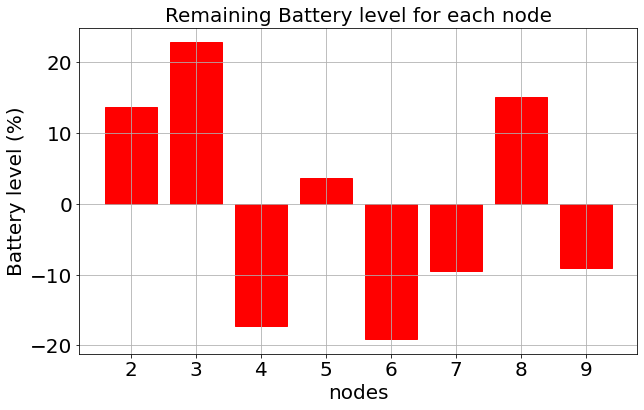

In [11]:
env.simulate(noise_type='both',
            n_iter_per_EsN0dB = 40,
            source = 1,
            relay_selection='max-min',
            nSym = 1000,
            min_EbN0dB = 0,
            max_EbN0dB = 20,
            EbN0dB_step = 2
            )